<h1 dir="rtl" align="right">
تمرین شماره ۲ درس بازیابی هوشمند اطلاعات – دانشگاه تهران، پاییز ۱۴۰۴
</h1>


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
نام: روژین پناو
<br/>
شماره دانشجویی: 220701046

تأیید می‌کنم که از LLMها مطابق با دستورالعمل‌های بارگذاری شده در سامانه Elearn درس به طور مسئولانه استفاده کرده‌ام، تمام اجزای کار خود را درک می‌کنم و آماده بحث شفاهی درباره آن‌ها هستم.

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
سوالات خودتان را می‌توانید از طریق ایمیل
<code>roshandel2004@gmail.com</code>
 از طراح تمرین ۲ بپرسید.

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px; color: red; font-weight: bold;">
قوانین و توضیحاتی آخر فایل تمرین حتما به دقت مطالعه شود.
</div>

In [7]:
import torch
print(torch.cuda.is_available())              # باید True باشد
print(torch.cuda.get_device_name(0))          # نام GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((1000, 1000), device=device)  # تخصیص روی GPU
y = x @ x                                     # ضرب ماتریسی روی GPU


False


AssertionError: Torch not compiled with CUDA enabled

In [4]:
import sys
import math
import typing as t

sys.path.append('/content')

In [5]:
# !pip install ir_datasets

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import document_processing as dp
import query_processing as qp
import inverted_index as ii
import retrieval_models as rm
import evaluation as ev

import nltk
nltk.download('punkt_tab')


print("="*80)
print("IIR - Assignment 2")
print("="*80)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rozhin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


IIR - Assignment 2


In [6]:
print("\n Loading dataset...")

print("Loading and preprocessing documents...")
documents = dp.load_documents()
for idx, doc in enumerate(documents):
    doc.preprocess()
    if (idx + 1) % 40_000 == 0 or idx == len(documents) - 1:
        print(f"Processed {idx+1}/{len(documents)} documents")

print("Building inverted index...")
inverted_index = ii.InvertedIndex()
inverted_index.build_index(documents)

print("Loading and preprocessing queries...")
queries = qp.load_queries()
for query in queries:
    query.preprocess()

print("Loading relevance judgments...")
relevance_judgments = ev.load_relevance_judgments()

print(f"✓ Loaded {len(documents)} documents")
print(f"✓ Loaded {len(queries)} queries")
print(f"✓ Loaded relevance judgments for {len(relevance_judgments)} queries")


 Loading dataset...
Loading and preprocessing documents...
Processed 40000/403666 documents
Processed 80000/403666 documents
Processed 120000/403666 documents
Processed 160000/403666 documents
Processed 200000/403666 documents
Processed 240000/403666 documents
Processed 280000/403666 documents
Processed 320000/403666 documents
Processed 360000/403666 documents
Processed 400000/403666 documents
Processed 403666/403666 documents
Building inverted index...
Loading and preprocessing queries...
Loading relevance judgments...
✓ Loaded 403666 documents
✓ Loaded 200 queries
✓ Loaded relevance judgments for 200 queries


# **Question 1**

In [7]:
print(f"Number of documents: {len(documents)}")
print("First 3 documents:")
for d in documents[:3]:
    print(f"DocID={d.doc_id}, length={len(d.tokens)} tokens")

Number of documents: 403666
First 3 documents:
DocID=2020338_0, length=55 tokens
DocID=2020338_1, length=3 tokens
DocID=2020338_2, length=119 tokens


In [8]:
print(f"\nNumber of queries: {len(queries)}")
print("First 3 queries:")
for q in queries[:3]:
    print(f"QueryID={q.query_id}, text={q.text}, tokens={q.tokens}")



Number of queries: 200
First 3 queries:
QueryID=3990512, text=how can we get concentration onsomething?, tokens=['get', 'concentr', 'onsometh']
QueryID=714612, text=Why doesn't the water fall off  earth if it's round?, tokens=['water', 'fall', 'earth', 'round']
QueryID=2528767, text=How do I determine the charge of the iron ion in FeCl3?, tokens=['determin', 'charg', 'iron', 'ion', 'fecl']


In [9]:
print(f"\nTotal docs in inverted_index: {len(inverted_index.doc_lengths)}")
print("Sample doc_lengths (first 5):")
for doc_id, length in list(inverted_index.doc_lengths.items())[:5]:
    print(f"DocID={doc_id}, length={length}")



Total docs in inverted_index: 403666
Sample doc_lengths (first 5):
DocID=2020338_0, length=55
DocID=2020338_1, length=3
DocID=2020338_2, length=119
DocID=2020338_3, length=37
DocID=2874684_0, length=14


<div dir="rtl">

# الف

<div dir="rtl">

###  دسته‌بندی طول اسناد مجموعه ANTIQUE

برای تحلیل رفتار مدل‌های هموارسازی نسبت به طول اسناد، ابتدا اسناد مجموعه ANTIQUE بر اساس تعداد کلماتشان دسته‌بندی شدند:

- **کوتاه (Short):** کمتر از ۵۰ کلمه  
- **متوسط (Medium):** بین ۵۰ تا ۱۵۰ کلمه  
- **بلند (Long):** بیش از ۱۵۰ کلمه  

جدول زیر آمار توصیفی هر گروه را نشان می‌دهد:

| گروه   | تعداد اسناد | درصد از کل | میانگین طول | میانه طول | کمینه طول | بیشینه طول |
|--------|-------------|------------|-------------|-----------|------------|-------------|
| Short  | 375,441     | 93.01%     | 14.30       | 11        | 0          | 49          |
| Medium | 24,921      | 6.17%      | 74.77       | 67        | 50         | 150         |
| Long   | 3,304       | 0.82%      | 245.89      | 222       | 151        | 514         |


### بررسی

1. **غلبه اسناد کوتاه:**  
   بیش از ۹۳٪ اسناد در گروه کوتاه قرار دارند. این نشان می‌دهد که مجموعه ANTIQUE به‌شدت نامتوازن است و بیشتر پاسخ‌ها بسیار کوتاه هستند (میانگین ۱۴ کلمه).  

2. **اسناد متوسط:**  
   تنها حدود ۶٪ اسناد در گروه متوسط قرار دارند، با میانگین طول حدود ۷۵ کلمه. این گروه می‌تواند تعادلی بین کوتاه و بلند ایجاد کند و برای تحلیل کیفیت هموارسازی اهمیت دارد.  

3. **اسناد بلند:**  
   کمتر از ۱٪ اسناد بلند هستند، اما میانگین طول آن‌ها حدود ۲۴۶ کلمه است. این گروه کوچک ولی مهم است، زیرا مدل‌های هموارسازی در اسناد بلند معمولاً رفتار متفاوتی دارند (وابستگی کمتر به smoothing و بیشتر به دادهٔ واقعی سند).  


### نتیجه‌گیری اولیه

- **نامتوازن بودن توزیع طول:** بیشتر آزمایش‌ها تحت تأثیر اسناد کوتاه خواهند بود. بنابراین باید بررسی شود که آیا مدل‌های هموارسازی برای اسناد کوتاه عملکرد مناسبی دارند یا خیر.  
- **اهمیت گروه بلند:** هرچند تعدادشان کم است، اما اسناد بلند می‌توانند نشان دهند که مدل‌های هموارسازی در شرایطی که دادهٔ سند کافی است چگونه عمل می‌کنند.  
- **ارتباط با هموارسازی:**  
  - در اسناد کوتاه، smoothing bias شدیدتر خواهد بود چون دادهٔ سند کم است.  
  - در اسناد بلند، اثر هموارسازی کمتر می‌شود و تخمین MLE سند غالب خواهد بود.  


</div>

In [10]:
import pandas as pd

def get_doc_lengths(inverted_index):
    return dict(inverted_index.doc_lengths)

def categorize_lengths(doc_len_map, short_thr=50, long_thr=150):
    df = pd.DataFrame(list(doc_len_map.items()), columns=['doc_id','length'])
    df['group'] = pd.cut(
        df['length'],
        bins=[-1, short_thr-1, long_thr, float('inf')],
        labels=['Short','Medium','Long']
    )
    groups = {g: df.loc[df['group']==g,'doc_id'].tolist() for g in ['Short','Medium','Long']}
    return groups, df

def summarize_groups(df):
    total = len(df)
    summary = df.groupby('group')['length'].agg(
        count='count', mean_len='mean', median='median', min_len='min', max_len='max'
    ).reset_index()
    summary['percent'] = 100 * summary['count'] / total
    return summary.round(2)

In [11]:
doc_len_map = get_doc_lengths(inverted_index)
doc_groups, df_docs = categorize_lengths(doc_len_map)
summary_df = summarize_groups(df_docs)

print(summary_df)


    group   count  mean_len  median  min_len  max_len  percent
0   Short  375441     14.30    11.0        0       49    93.01
1  Medium   24921     74.77    67.0       50      150     6.17
2    Long    3304    245.89   222.0      151      514     0.82


<div dir="rtl">

# ب

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

# -----------------------------
# 1) رتبه‌بندی محدود به یک گروه
# -----------------------------
def rank_query_scores(scoring_method, query, inverted_index, param_name, param_value, doc_ids, top_k=None):
    scores = scoring_method(query, inverted_index, **{param_name: param_value})
    # فقط اسناد گروه
    filtered = {d: scores[d] for d in doc_ids if d in scores}
    ranked = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    # فقط لیست doc_id ها را نگه می‌داریم (مصرف حافظه کم)
    docs = [doc for doc, _ in ranked]
    if top_k is not None:
        docs = docs[:top_k]
    return docs

def precompute_rankings(scoring_method, queries, inverted_index, param_name, param_value, doc_ids, top_k=None):
    # خروجی: {qid: [doc_id, ...]} فقط برای گروه مشخص
    return {
        q.query_id: rank_query_scores(scoring_method, q, inverted_index, param_name, param_value, doc_ids, top_k)
        for q in queries
    }

# ---------------------------------
# 2) محاسبهٔ معیارها بر اساس رتبه‌ها
# ---------------------------------
def compute_selected_metrics(all_retrieved_docs, relevance_judgments, min_relevant=3):
    # MAP
    map_score = ev.EvaluationMetrics.mean_average_precision(
        all_retrieved_docs, relevance_judgments, min_relevant
    )
    # MRR اگر لازم شد می‌توانی اضافه کنی
    # mrr_score = ev.EvaluationMetrics.mean_reciprocal_rank(all_retrieved_docs, relevance_judgments, min_relevant)

    # Precision@5
    p5 = np.mean([
        ev.EvaluationMetrics.precision_at_k(docs, relevance_judgments.get(qid, {}), 5, min_relevant)
        for qid, docs in all_retrieved_docs.items()
    ])

    # Recall@10
    r10 = np.mean([
        ev.EvaluationMetrics.recall_at_k(docs, relevance_judgments.get(qid, {}), 10, min_relevant)
        for qid, docs in all_retrieved_docs.items()
    ])

    # nDCG@5
    ndcg5 = np.mean([
        ev.EvaluationMetrics.ndcg(docs, relevance_judgments.get(qid, {}), 5, min_relevant)
        for qid, docs in all_retrieved_docs.items()
    ])

    return {
        'MAP': round(float(map_score), 4),
        'Precision@5': round(float(p5), 4),
        'Recall@10': round(float(r10), 4),
        'nDCG@5': round(float(ndcg5), 4),
    }


# -------------------------------------------
# 3) اجرای sweep پارامترها برای هر گروه اسناد
# -------------------------------------------
def sweep_parameters_grouped(scoring_method, queries, inverted_index, relevance_judgments,
                             doc_groups, param_name, param_values, top_k=1000, min_relevant=3):
    records = []
    for val in param_values:
        for group_name, doc_ids in doc_groups.items():
            # یک‌بار رتبه‌بندی محدود به این گروه و این مقدار پارامتر
            rankings = precompute_rankings(scoring_method, queries, inverted_index, param_name, val, doc_ids, top_k)
            # محاسبهٔ معیارها روی همین رتبه‌ها
            metrics = compute_metrics_for_rankings(rankings, relevance_judgments, min_relevant)
            metrics[param_name] = val
            metrics['group'] = group_name
            records.append(metrics)
            # آزادسازی حافظه
            del rankings
            gc.collect()
    return pd.DataFrame(records)

# ----------------------
# 4) رسم نمودار هر روش
# ----------------------
def plot_metrics(df, param_name, title):
    metrics = ['MAP','MRR','Precision@3','Precision@10','Recall@3','Recall@10','nDCG@10']
    fig, axes = plt.subplots(3,3, figsize=(15,12))
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        for g in df['group'].unique():
            sub = df[df['group']==g].sort_values(param_name)
            axes[i].plot(sub[param_name], sub[m], marker='o', label=g)
        axes[i].set_title(m)
        axes[i].set_xlabel(param_name)
        axes[i].set_ylabel(m)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


<div dir="rtl">

### روش Jelinek–Mercer

این روش احتمال کلمات را با ترکیب دو بخش محاسبه می‌کند:

<p dir="rtl">
- احتمال در سند: \(\ P_{ML}(w|d) \)
</p>
<p dir="rtl">
- احتمال در مجموعه: \(\ P(w|C) \)
</p>

<br>

$$
P(w|d) = (1 - \lambda) \cdot P_{ML}(w|d) + \lambda \cdot P(w|C)
$$

<br>
</div>

<p dir="rtl">
در اینجا \(\lambda\) پارامتر تنظیمی است که میزان اتکا به مجموعه کلی را مشخص می‌کند.  
این روش مشکل احتمال صفر را برطرف می‌کند و باعث می‌شود حتی کلمات دیده‌نشده در سند، احتمال غیر صفر داشته باشند.
</p>



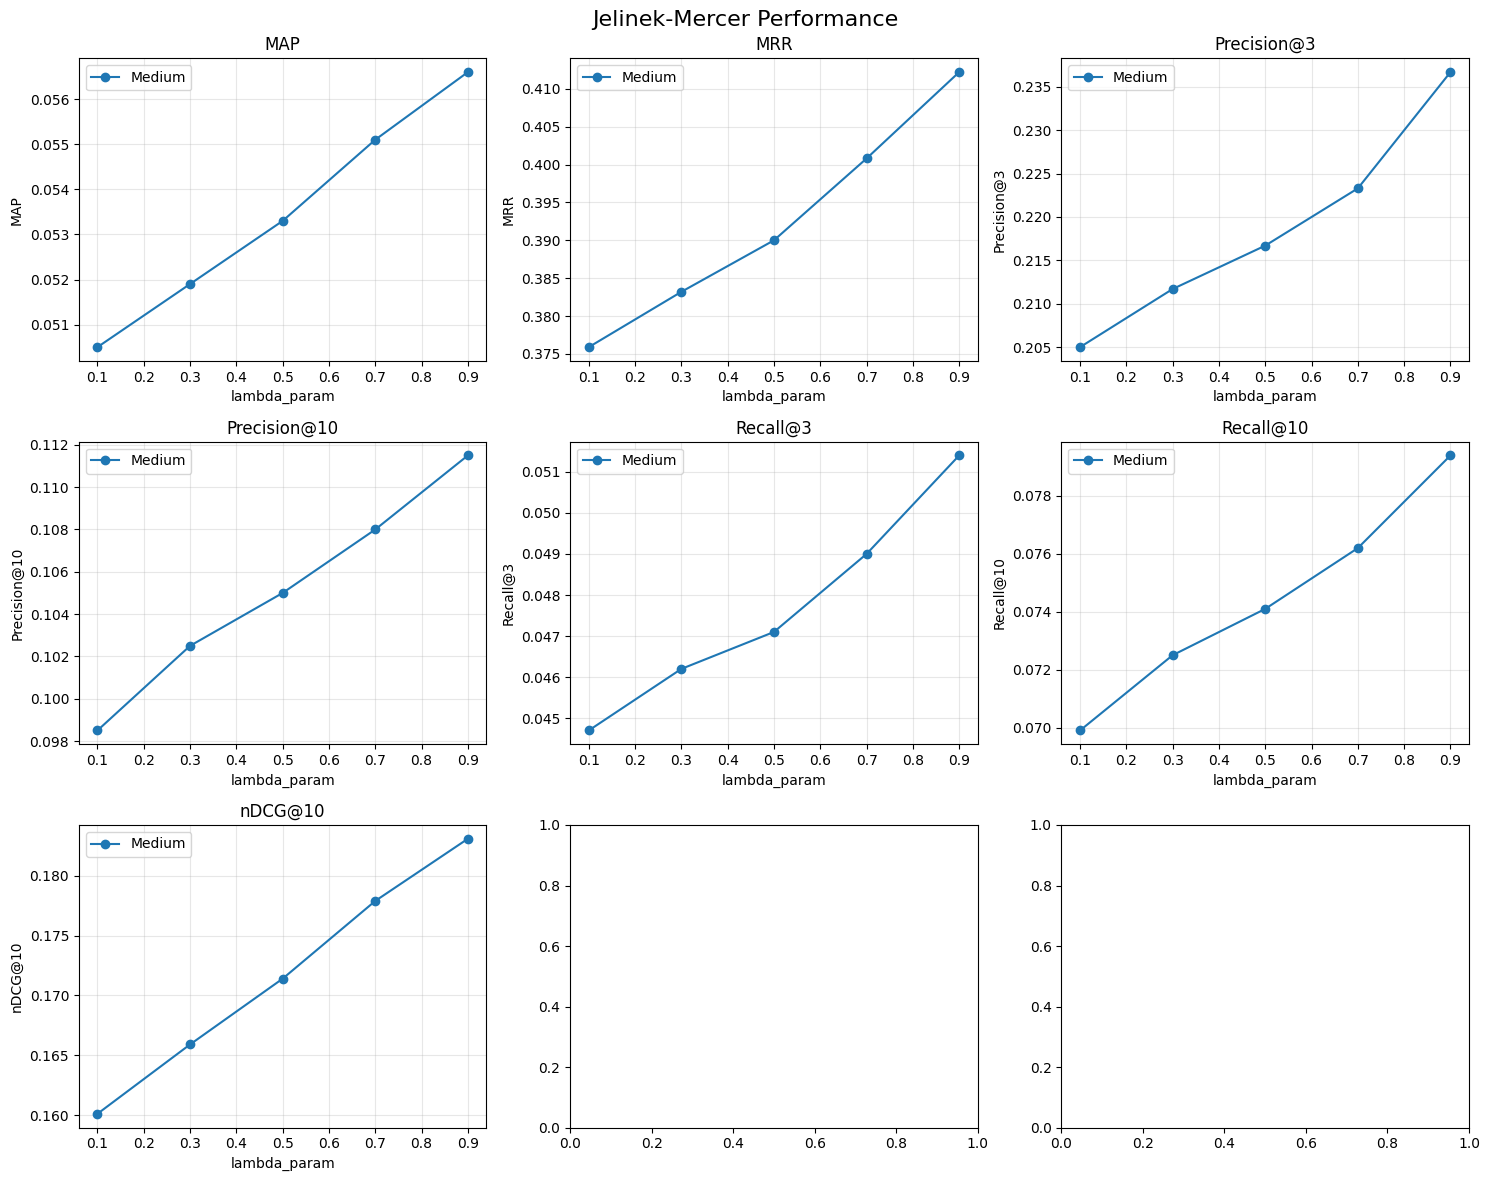

,MAP,MRR,Precision@3,Precision@10,Recall@3,Recall@10,nDCG@10,lambda_param,group
0,0.0505,0.3759,0.2050,0.0985,0.0447,0.0699,0.1601,0.1,Medium
1,0.0519,0.3832,0.2117,0.1025,0.0462,0.0725,0.1659,0.3,Medium
2,0.0533,0.3900,0.2167,0.1050,0.0471,0.0741,0.1714,0.5,Medium
3,0.0551,0.4008,0.2233,0.1080,0.0490,0.0762,0.1779,0.7,Medium
4,0.0566,0.4122,0.2367,0.1115,0.0514,0.0794,0.1831,0.9,Medium


In [13]:
# lambda_values = [0.1,0.3,0.5,0.7,0.9]

# jm_df = sweep_parameters_grouped(
#     rm.jelinek_mercer_score,
#     queries,
#     inverted_index,
#     relevance_judgments,
#     {'Medium': doc_groups['Medium']},
#     'lambda_param',
#     lambda_values
# )

# plot_metrics(jm_df, 'lambda_param', 'Jelinek-Mercer Performance')
# display(jm_df)

<div dir="rtl">

### روش Dirichlet Prior

این روش هموارسازی با استفاده از **پیشین دیریکله** انجام می‌شود.  
ایده اصلی این است که تعداد رخدادهای کلمات در سند با یک مقدار پیشین از کل مجموعه ترکیب شود:

<p dir="rtl">
- تعداد رخداد کلمه در سند: \(c(w,d)\)
</p>
<p dir="rtl">
- طول سند: \(|d|\)
</p>
<p dir="rtl">
- پارامتر هموارسازی: \(\mu\)
</p>

<br>

$$
P(w|d) = \frac{c(w,d) + \mu \cdot P(w|C)}{|d| + \mu}
$$

<br>

</div>

<p dir="rtl">
این روش باعث می‌شود اسناد کوتاه بیشتر تحت تأثیر مجموعه کلی قرار بگیرند،  
در حالی که اسناد بلندتر بیشتر به محتوای خودشان متکی باشند.
</p>


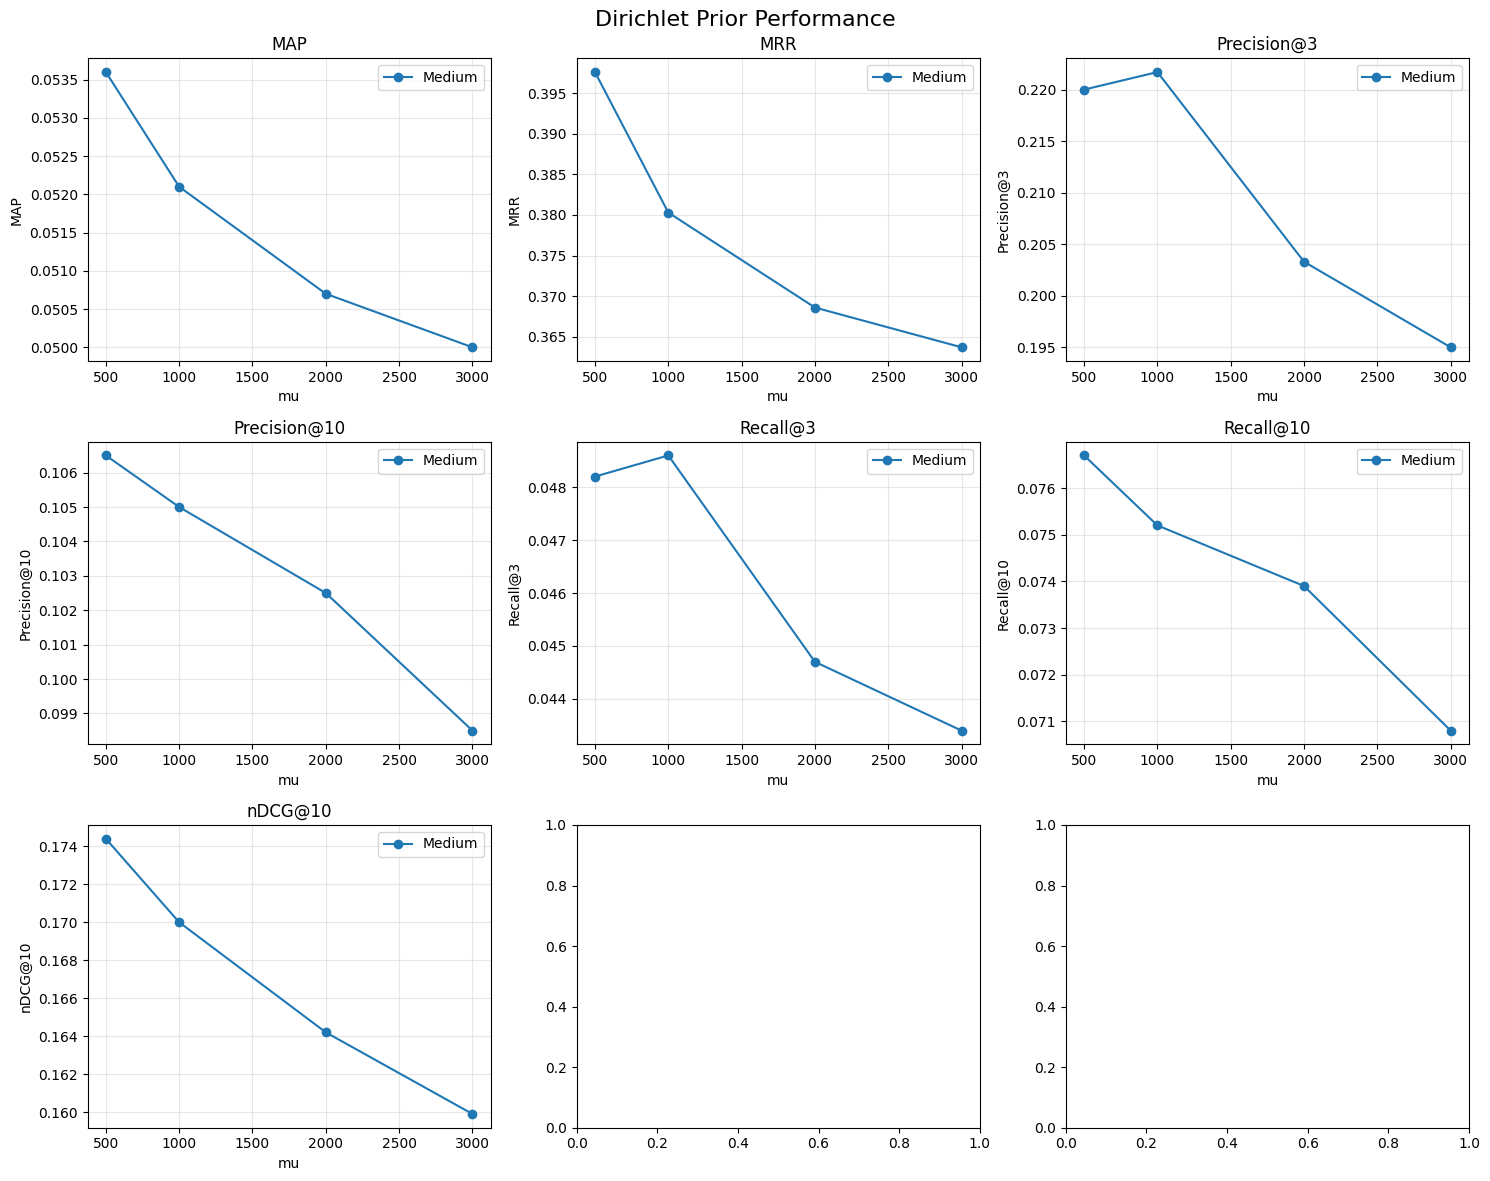

,MAP,MRR,Precision@3,Precision@10,Recall@3,Recall@10,nDCG@10,mu,group
0,0.0536,0.3976,0.2200,0.1065,0.0482,0.0767,0.1744,500,Medium
1,0.0521,0.3803,0.2217,0.1050,0.0486,0.0752,0.1700,1000,Medium
2,0.0507,0.3686,0.2033,0.1025,0.0447,0.0739,0.1642,2000,Medium
3,0.0500,0.3637,0.1950,0.0985,0.0434,0.0708,0.1599,3000,Medium


from matplotlib import pyplot as plt
dir_df['MAP'].plot(kind='hist', bins=20, title='MAP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df['MRR'].plot(kind='hist', bins=20, title='MRR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df['Precision@3'].plot(kind='hist', bins=20, title='Precision@3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df['Precision@10'].plot(kind='hist', bins=20, title='Precision@10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df.plot(kind='scatter', x='MAP', y='MRR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df.plot(kind='scatter', x='MRR', y='Precision@3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df.plot(kind='scatter', x='Precision@3', y='Precision@10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dir_df.plot(kind='scatter', x='Precision@10', y='Recall@3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mu']
  ys = series['MAP']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dir_df.sort_values('mu', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mu')
_ = plt.ylabel('MAP')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mu']
  ys = series['MRR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dir_df.sort_values('mu', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mu')
_ = plt.ylabel('MRR')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mu']
  ys = series['Precision@3']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dir_df.sort_values('mu', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mu')
_ = plt.ylabel('Precision@3')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mu']
  ys = series['Precision@10']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dir_df.sort_values('mu', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mu')
_ = plt.ylabel('Precision@10')

from matplotlib import pyplot as plt
dir_df['MAP'].plot(kind='line', figsize=(8, 4), title='MAP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dir_df['MRR'].plot(kind='line', figsize=(8, 4), title='MRR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dir_df['Precision@3'].plot(kind='line', figsize=(8, 4), title='Precision@3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dir_df['Precision@10'].plot(kind='line', figsize=(8, 4), title='Precision@10')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
# mu_values = [500,1000,2000,3000]

# dir_df = sweep_parameters_grouped(
#     rm.dirichlet_prior_score,
#     queries,
#     inverted_index,
#     relevance_judgments,
#     {'Medium': doc_groups['Medium']},
#     'mu',
#     mu_values
# )

# plot_metrics(dir_df, 'mu', 'Dirichlet Prior Performance')
# display(dir_df)

<div dir="rtl">

### روش Absolute Discounting

در این روش، به‌جای صفر کردن احتمال کلمات دیده‌نشده، بخشی از احتمال کلمات دیده‌شده کم می‌شود و به کلمات دیده‌نشده اختصاص داده می‌شود:

<p dir="rtl">
- فراوانی کلمه در سند: \(P(w,d)\)  
</p>
<p dir="rtl">
- طول سند: \(|d|\)
</p>
<p dir="rtl">
- تعداد کلمات یکتای سند: \(|d|_u\)  
</p>
<p dir="rtl">
- پارامتر تخفیف: \(\delta\)
</p>

</div>

<br>

$$
P(w|d) = \frac{\max(P(w,d) - \delta, 0)}{|d|} + \frac{\delta \cdot |d|_u}{|d|} \cdot P(w|C)
$$

<br>

<p dir="rtl">
این روش تعادلی بین کلمات دیده‌شده و دیده‌نشده برقرار می‌کند و باعث می‌شود همه کلمات احتمال غیر صفر داشته باشند.
</p>


In [ ]:
delta_values = [0.1,0.5,0.7,1.0]

ad_df = sweep_parameters_grouped(
    rm.absolute_discounting_score,
    queries,
    inverted_index,
    relevance_judgments,
    {'Medium': doc_groups['Medium']},
    'delta',
    delta_values
)

plot_metrics(ad_df, 'delta', 'Absolute Discounting Performance')
display(ad_df)

# **Question 2**

In [ ]:
#YOUR CODE HERE

# **نکات مهم**

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
    <p><strong>مهلت تحویل بدون جریمه:</strong> ۲۷ آبان ۱۴۰۴</p>
    <p><strong>مهلت تحویل با تاخیر (با جریمه):</strong>۴ آذر ۱۴۰۴</p>
</div>
<h4 dir="rtl" style="font-family: Vazir; width: 85%;">فایل ارسالی شما باید با فرمت زیر نامگذاری شود: <code>IIR_CA2_STUDENTID.ipynb</code></h4>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">نحوه انجام این تمرین:</h4>
<ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;"> <li>برخی سوالات نیاز به نوشتن کد پایتون و محاسبه نتایج دارند کدها بایستی طبق فایل تمرین به طور کامل نوشته شوند.</li> <li> کدها و تفسیرهای هربخش را به طور مشخص در همین نوت‌بوک بنویسید. سعی کنید هربخش به طور مشخصی جداشده باشد و ساختار نوت‌بوک خوانا باشد.</li>  </ul>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">صداقت علمی:</h4> <ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;"> <li>ما نوت‌بوک‌های تعداد مشخصی از دانشجویان که به صورت تصادفی انتخاب می‌شوند، بررسی خواهیم کرد. این بررسی‌ها اطمینان حاصل می‌کنند که کدی که نوشتید واقعاً پاسخ‌های موجود در نوت‌بوک شما را تولید می‌کند. اگر پاسخ‌های صحیح را در نوت‌بوک خود بدون کدی که واقعاً آن پاسخ‌ها را تولید کند تحویل دهید، این یک مورد جدی از عدم صداقت علمی محسوب می‌شود.</li> <li>ما همچنین بررسی‌های خودکاری را برای تشخیص سرقت علمی در نوت‌بوک‌های کولب انجام خواهیم داد. کپی کردن کد از دیگران نیز یک مورد جدی از عدم صداقت علمی محسوب می‌شود.</li> </ul>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">توضیحات تکمیلی:</h4> <ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
<li>
خوانایی و دقت بررسی‌ها در گزارش نهایی از اهمیت ویژه‌ای برخوردار است. به تمرین‌هایی که به صورت کاغذی تحویل داده شوند یا به صورت عکس در سایت بارگذاری شوند، ترتیب اثری داده نخواهد شد.</li>
<li>
 همه‌ی کدهای پیوست گزارش بایستی قابلیت اجرای مجدد داشته باشند. در صورتی که برای اجرا مجدد آن‌ها نیاز به تنظیمات خاصی می‌باشد، بایستی تنظیمات مورد نیاز را نیز در گزارش خود ذکر کنید.  دقت کنید که  تمامی کدها باید توسط شما اجرا شده باشند و نتایج اجرا در فایل کدهای ارسالی مشخص باشد. به کدهایی که نتایج اجرای آن‌ها در فایل ارسالی مشخص نباشد نمره‌ای تعلق نمی‌گیرد.
</li>
<li>
تمرین تا یک هفته بعد از مهلت تعیین شده با تاخیر تحویل گرفته می‌شود. دقت کنید که شما جمعاً برای تمام تکالیف، ۱۴ روز زمان تحویل بدون جریمه دارید که تنها از ۷ روز آن برای هر تمرین می‌توانید استفاده کنید. در صورتی که این ۱۴ روز به اتمام رسیده باشد، به ازای هر روز تاخیر ده درصد جریمه می‌شود.
</li>
<li>توجه کنید این تمرین باید به صورت تک‌نفره انجام شود و پاسخ‌های ارائه شده باید نتیجه فعالیت فرد نویسنده باشد (همفکری و به اتفاق هم نوشتن تمرین نیز ممنوع است). در صورت مشاهده
 تشابه به همه افراد مشارکت‌کننده، نمره تمرین صفر و به استاد گزارش می‌گردد.
 </li>
 <li>برای مطالعه بیشتر درباره‌ی فرمت مارک‌دون می‌توانید از <a href="https://github.com/tajaddini/Persian-Markdown/blob/master/learn-MD.md">این لینک</a> مطالعه کنید.
 </li>

 </ul>
 </div>